# Modelling Rocket Trajectories

This python program is developed to understand the fundamental physics and mathematics governing the trajectory dynamics of rockets. The development of rocket trajectory equations follows a systematic progression by incorporating variables in an ascending order of complexity. The sequence of variables is as follows :
- Gravitational effects
- Accleration due to the thrust force
- Aerodynamic drag forces
- Changes in air density relative altitude
- Changes in drag coefficient relative to mach number

In [2]:
# importing libraries
import math
import pandas as pd
import numpy as np
from scipy.interpolate import interp1d
import matplotlib.pyplot as plt

In [3]:
# importing lookup tables
file_path = "lookup table 1.csv" # lookup table for interpolating temperature as altitude changes
df = pd.read_csv(file_path)

file_path1 = "lookup table 2.csv" # lookup table for interpolating speed of sound as temperature changes
df1 = pd.read_csv(file_path1)

file_path2 = "lookup table 3.csv" # lookup table for interpolating drag coefficient as mach number changes
df2 = pd.read_csv(file_path2)

# interpolation of look up tables
interp_temperature = interp1d(df['Altitude'], df['Temperature'], kind ='linear', bounds_error=False)
interp_speed_of_sound = interp1d(df1['Temperature'], df1['Speed Of sound'], kind ='linear', bounds_error=False )
lower_interp = interp1d(df2['Mach Number'], df2['Drag Coefficient'], kind='cubic', bounds_error=False, fill_value=0.43)
upper_interp = interp1d(df2['Mach Number'], df2['Drag Coefficient'], kind='cubic', bounds_error=False, fill_value=0.22)
    

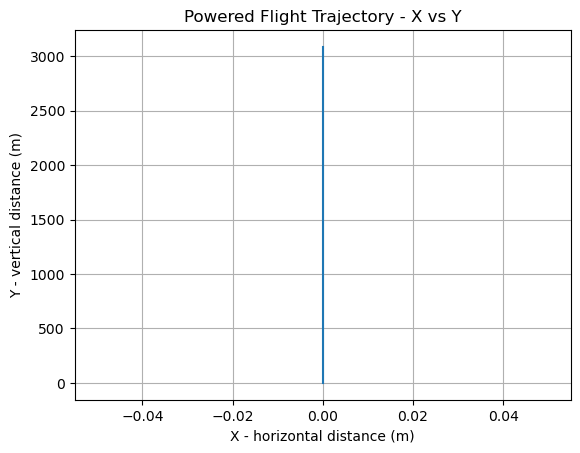

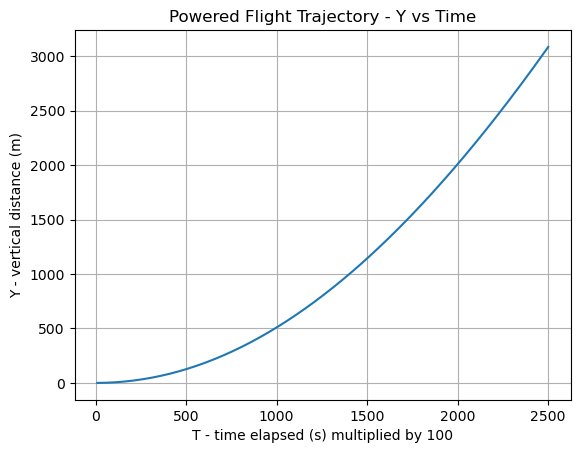

In [4]:
# function for mapping the powered flight trajectory
def powered_trajectory(mi, mf, isp, m_dot, A, Me, G, Re, Cd, dt): # defining function to take input of the variables
    
    T = isp * m_dot  # thrust produced 
    acc = T / mi  # acceleration due to thrust 
    t_max = (mi - mf) / m_dot # time for fuel to exhaust
    
    # initial values
    t = 0
    x = 0
    y = 0
    vx = 0
    vy = 0
    
    # creating arrays to store x,y,v,t 
    time_array = []
    x_array = []
    y_array = []
    v_array = []
    
    # loop for powered flight
    while t <= t_max: 
        m = mi - (m_dot * 0.1) # fuel mass being exhausted at a specific mass flow rate (kg per second)
        mi = m # updation of mi value as the fuel is exhausted
    
        rho = 1.12250 * math.exp(- y / 8500) # calculation of air density with change in altitute 
        # condition : temperature of the atmosphere and value of g remains a constant
    
        temp = interp_temperature(y) # interpolation of temperature
        vs = interp_speed_of_sound(temp) # interpolation of speed of sound

        v = (vx ** 2 + vy ** 2) ** 0.5 # total velocity
        mach_no = v / vs # mach number
    
        def combined_interp(mach_no): # function that defines values outside interpolation range for mach number
            if mach_no < df2['Mach Number'].min():
                return lower_interp(df2['Mach Number'].min())
            elif mach_no > df2['Mach Number'].max():
                return upper_interp(df2['Mach Number'].max())
            else:
                return lower_interp(mach_no) if mach_no <= df2['Mach Number'].max() else upper_interp(mach_no)
    
        Cd = combined_interp(mach_no) # interpolation of drag coefficient
    
        F_dx = 0.5 * rho * (vx ** 2) * A * Cd # equation for drag coefficient in the x direction
        F_dy = 0.5 * rho * (vy ** 2) * A * Cd # equation for drag coefficient in the y direction
    
        g = (G * Me) / (Re + y) ** 2 # variation of acceleration due to gravity with change in altitude

        dx = 0.5 * (0 - (F_dx / m)) * dt ** 2 # equation of motion in the x direction (for dt change in time)
        dy = 0.5 * (-g - (F_dy / m) + ((T / mi) * g)) * dt ** 2 # equation of motion in the y direction (for dt change in time)

        dvx = 0 # small change in velocity in the x direction will be zero as g is zero in the x direction
        dvy = (-g - (F_dy / mi) + ((T / mi) * g)) * dt # small change in velocity in the y direction 

        x = x + (vx * dt) + dx # equation of motion in x direction
        y = y + (vy * dt) + dy # equation of motion in y direction
        vx = vx + dvx # velocity in x direction
        vy = vy + dvy # velocity in y direction
        t = t + dt # total time
        v = (vx ** 2 + vy ** 2) ** 0.5 # total velocity
    
        # storing of values in the array
        time_array = np.append(time_array, t * 100) 
        x_array = np.append(x_array, x)
        y_array = np.append(y_array, y)
        v_array = np.append(v_array,v)
    
    return time_array, x_array, y_array, v_array

# parametric variation of mass flow rate (0.095,0.1,0.105 kg per sec)
time_result, x_result, y_result, v_result = powered_trajectory(10, 7.5, 200, 0.1, (3.145 * (0.05**2)), (5.972 * 10**(24)), (6.6743 * 10**(-11)), 6371000, 0.1, 0.1)

# creating plot for the above parametric variation
plt.plot(x_result, y_result)
plt.xlabel('X - horizontal distance (m)')
plt.ylabel('Y - vertical distance (m)')
plt.title('Powered Flight Trajectory - X vs Y')
plt.grid(True)
plt.show()

plt.plot(time_result, y_result)
plt.xlabel('T - time elapsed (s) multiplied by 100')
plt.ylabel('Y - vertical distance (m)')
plt.title('Powered Flight Trajectory - Y vs Time')
plt.grid(True)
plt.show()


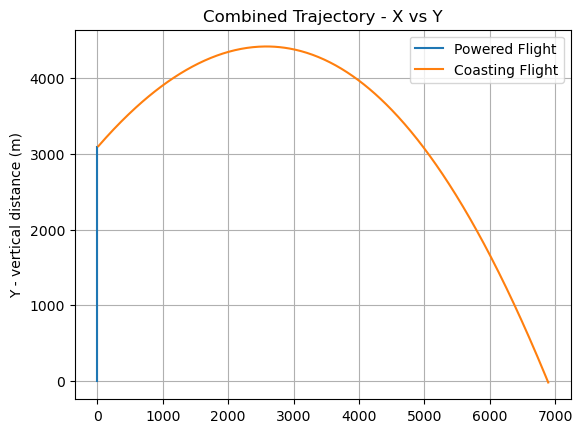

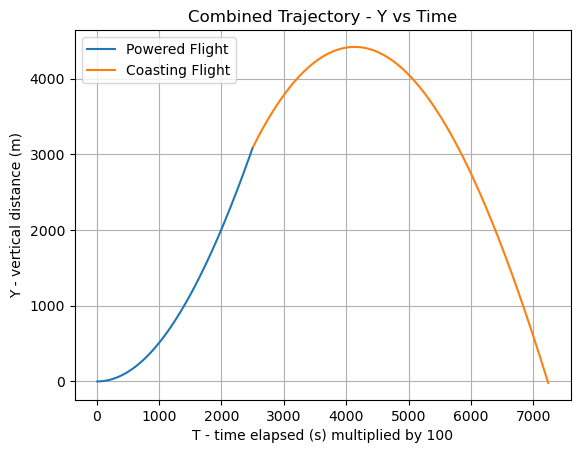

In [5]:
# function for mapping the coasting flight trajectory
def coasting_trajectory(v0, t1, angle, x1, y1, Cd1, A, Me, G, Re):
    
    # initial values
    x1 = 0
    dt1 = 0.1
    m = 7.5
    
    # converting angle from degrees to radians and splitting the components of velocity
    angle_radians = np.radians(angle)
    v0x = v0 * np.cos(angle_radians) 
    v0y = v0 * np.sin(angle_radians)
   
    # creating arrays to store x,y,t
    time_coasting_array = np.array([])
    x_coasting_array = np.array([])
    y_coasting_array = np.array([])

    # loop for coasting flight
    while y1 >= 0:

        rho = 1.12250 * math.exp(- y1 / 8500) # calculation of air density with change in altitute 
        # condition : temperature of the atmosphere and value of g remains a constant

        temp = interp_temperature(y1) # interpolation of temperature
        vs = interp_speed_of_sound(temp) # interpolation of speed of sound

        v0 = (v0x ** 2 + v0y ** 2) ** 0.5 # total velocity
        mach_no = v0 / vs # mach number

        def combined_interp(mach_no): # function that defines values outside interpolation range for mach number
            if mach_no < df2['Mach Number'].min():
                return lower_interp(df2['Mach Number'].min())
            elif mach_no > df2['Mach Number'].max():
                return upper_interp(df2['Mach Number'].max())
            else:
                return lower_interp(mach_no) if mach_no <= df2['Mach Number'].max() else upper_interp(mach_no)

        Cd = combined_interp(mach_no) # interpolation of drag coefficient

        F_d_x = 0.5 * rho * (v0x ** 2) * A * Cd1 # equation for drag coefficient in the x direction
        F_d_y = 0.5 * rho * (v0y ** 2) * A * Cd1 # equation for drag coefficient in the y direction

        g = (G * Me) / (Re + y1) ** 2 # variation of acceleration due to gravity with change in altitude

        dx1 = 0.5 * (- (F_d_x/m)) * (dt1**2) # equation of motion in the x direction (for dt change in time)
        dy1 = 0.5 * ((- g) - (F_d_y/m)) * (dt1**2) # equation of motion in the y direction (for dt change in time)

        dvx1 = (- F_d_x / m) * dt1 # small change in velocity in the x direction 

        if v0y >= 0: 
            dvy1 = (- g - (F_d_y / m)) * dt1 # acceleration due to drag is in the same direction wrt g 
        else:
            dvy1 = (- g + (F_d_y / m)) * dt1 # acceleration due to drag is in the opposite direction wrt g

        x1 += (v0x * dt1) + dx1 # equation of motion in x direction
        y1 += (v0y * dt1) + dy1 # equation of motion in y direction

        if y1 > 100000:
            print("Object has crossed Von Karman line")
            break

        v0x = v0x + dvx1 # velocity in x direction
        v0y = v0y + dvy1 # velocity in y direction
        t1 = t1 + dt1 # total time

        v0 = (v0x ** 2 + v0y ** 2) ** 0.5
        if v0 > 11800 :
            print("Object has escaped gravity")
            break
            
        # storing of values in the array
        time_coasting_array = np.append(time_coasting_array, t1*100)
        x_coasting_array = np.append(x_coasting_array, x1)
        y_coasting_array = np.append(y_coasting_array, y1)
        
    return time_coasting_array, x_coasting_array, y_coasting_array


# parametric variation of mass flow rate (0.095,0.1,0.105 kg per sec)
time_coasting_result, x_coasting_result, y_coasting_result = coasting_trajectory(v_result[-1],time_result[-1]/100, 45, x_result[-1], y_result[-1], 0.1,(3.145 * (0.05**2)), (5.972 * 10**(24)), (6.6743 * 10**(-11)), 6371000) 

# creating plot for the above parametric variation
plt.plot(x_result, y_result, label = "Powered Flight")
plt.plot(x_coasting_result, y_coasting_result, label = "Coasting Flight")
plt.ylabel('Y - vertical distance (m)')
plt.title('Combined Trajectory - X vs Y')
plt.grid(True)
plt.legend()
plt.show()

plt.plot(time_result, y_result, label = "Powered Flight")
plt.plot(time_coasting_result, y_coasting_result, label = "Coasting Flight")
plt.xlabel('T - time elapsed (s) multiplied by 100')
plt.ylabel('Y - vertical distance (m)')
plt.title('Combined Trajectory - Y vs Time')
plt.grid(True)
plt.legend()
plt.show()
